In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l1
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load Data
data = pd.read_csv("auckland_data1_continuous.csv")

In [3]:
# Display the First Few Values of the Date Column
print(data['Date'].head())

# Check for Non-standard or Missing Date Values
print(data['Date'].unique())

0    2020/1/1
1    2020/1/2
2    2020/1/3
3    2020/1/4
4    2020/1/5
Name: Date, dtype: object
['2020/1/1' '2020/1/2' '2020/1/3' ... '2023/8/21' '2023/8/22' '2023/8/23']


In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')

In [5]:
data['Date'] = data['Date'].apply(lambda x: x.value) #Total Nanoseconds from 1970-01-01 00:00:00 UTC to That Datetime 

In [6]:
#data['Date'] = pd.to_datetime(data['Date'])
#data['Month'] = data['Date'].dt.month
#data['DayOfWeek'] = data['Date'].dt.dayofweek
#data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x > 4 else 0)

# Data Preprocessing
# Fill with Median
#data = data.fillna(data.median())

#for col in data.columns:
#    # Consider Only Non-dash Values for Median Calculation
#    median = pd.to_numeric(data[col], errors='coerce').median()
#    # Replace Dashes with Median
#    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(median)
# Convert Non-numeric Data to Numeric and Handle Missing Values
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.fillna(data.median())

# Define a Function to Handle Outliers
def replace_outliers(data, n_std=3):
    for column in data.select_dtypes(include=np.number).columns:
        mean = data[column].mean()
        std = data[column].std()
        
        # Calculate Threshold for Outliers
        upper_bound = mean + n_std * std
        lower_bound = mean - n_std * std

        # Replace Outliers 
        data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
        data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    
    return data

# Identify Features and Target Variable
features = data.drop(columns=['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)'])
target = data[['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)']]

# Normalization
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_features = scaler.fit_transform(features)
#scaled_target = scaler.fit_transform(target)
#---------------
# Create a MinMaxScaler Instance for Input Features
input_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = input_scaler.fit_transform(features)

# Create Another MinMaxScaler Instance for the Target Variable 
output_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = output_scaler.fit_transform(target)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42, shuffle=True)


In [7]:
# Save Both Scaler Instances Separately
import joblib
joblib.dump(input_scaler, 'Auckland_input_scaler.pkl')
joblib.dump(output_scaler, 'Auckland_output_scaler.pkl')

['Auckland_output_scaler.pkl']

In [8]:
data['Date']

0       1577836800000000000
1       1577923200000000000
2       1578009600000000000
3       1578096000000000000
4       1578182400000000000
               ...         
1326    1692403200000000000
1327    1692489600000000000
1328    1692576000000000000
1329    1692662400000000000
1330    1692748800000000000
Name: Date, Length: 1331, dtype: int64

In [9]:
# Adjust Data Shape for CNN and LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, MaxPooling1D
# Calculate the Number of Features
n_features = features.shape[1]
feature_names = features.columns

# Build LSTM Model
#model = Sequential([
#    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
#   Dropout(0.2),
 #   LSTM(100, return_sequences=False, activation='relu'),
 #   Dropout(0.2),
 #   Dense(2)
#])
#model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

model = Sequential()
# CNN layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(2))

# Compile the Model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# Set Early Stopping to Avoid Overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=64, 
    verbose=2, 
    shuffle=False, 
    validation_split=0.1, 
    callbacks=[early_stopping]
)


Epoch 1/100
15/15 - 1s - loss: 0.2362 - val_loss: 0.0939 - 909ms/epoch - 61ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0446 - val_loss: 0.0251 - 46ms/epoch - 3ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0232 - val_loss: 0.0197 - 53ms/epoch - 4ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0201 - val_loss: 0.0188 - 54ms/epoch - 4ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0198 - val_loss: 0.0183 - 53ms/epoch - 4ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0188 - val_loss: 0.0181 - 54ms/epoch - 4ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0181 - val_loss: 0.0177 - 58ms/epoch - 4ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0176 - val_loss: 0.0173 - 58ms/epoch - 4ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0180 - val_loss: 0.0173 - 58ms/epoch - 4ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0166 - val_loss: 0.0167 - 58ms/epoch - 4ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0162 - val_loss: 0.0165 - 75ms/epoch - 5ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0162 - val_loss: 0.0163 - 86ms/epoch - 6ms/step
Epoch 13/100
15/15 - 0s

In [11]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.011941026896238327


In [12]:
# Prediction
predictions = model.predict(X_test)
#------------------
# Inverse Transform Predictions and Actual Values
#predictions_inversed = scaler.inverse_transform(predictions)
#y_test_inversed = scaler.inverse_transform(y_test)
#--------------
# Use the MinMaxScaler Instance of Output Data to Inverse Scale Predictions 
predictions_inversed = output_scaler.inverse_transform(predictions)

# Use the MinMaxScaler Instance of Output Data to Inverse Scale True Test Data
y_test_inversed = output_scaler.inverse_transform(y_test)

# Calculate Evaluation Metrics
mse = mean_squared_error(y_test_inversed, predictions_inversed)
mae = mean_absolute_error(y_test_inversed, predictions_inversed)
r2 = r2_score(y_test_inversed, predictions_inversed)

# Print Evaluation Metrics
print("Mean Squared Error (MSE): ", mse)
print("Mean Absolute Error (MAE): ", mae)
print("R² Score: ", r2)

9/9 [==============================] - 0s 899us/step
Mean Squared Error (MSE):  11.333658112660647
Mean Absolute Error (MAE):  2.4264163834473886
R² Score:  -0.1580424976373731


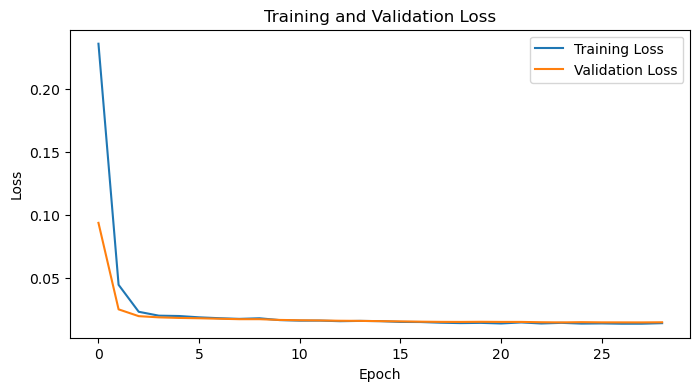

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


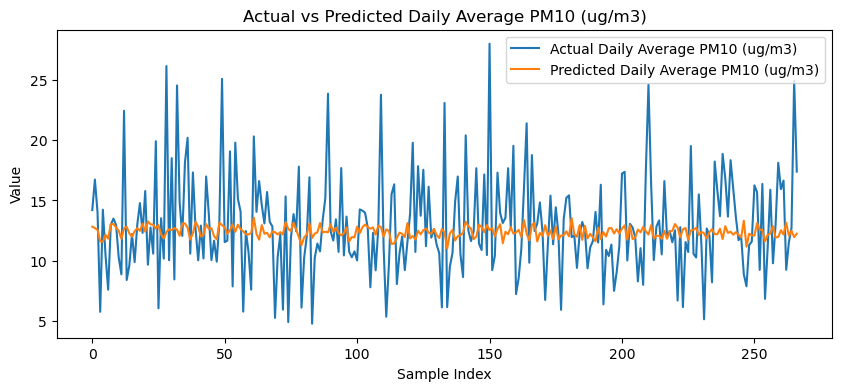

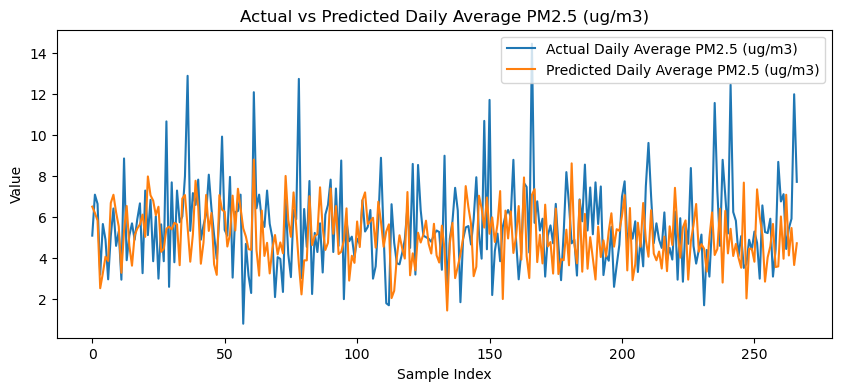

In [14]:
# Plot Predictions vs. Actual Values
target_labels = ['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)']
for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inversed[:, i], label=f'Actual {target_labels[i]}')
    plt.plot(predictions_inversed[:, i], label=f'Predicted {target_labels[i]}')
    plt.title(f'Actual vs Predicted {target_labels[i]}')
    plt.ylabel('Value')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.show()


In [15]:
# Save the Entire Model to an HDF5 File
model.save('/Users/yangyi/Auckland_model.h5')

/Users/yangyi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
